# Script para obtener datos de mortalidad
El siguiente notebook tiene como objetivo establecer el impacto del corona virus en la tasa de moratalidad en Chile

## Datos históricos de mortalidad
La búsqueda de datos sobre mortalidad ha resultado ser una difícil tarea, de hecho la data histórica desagregada a nivel granular de defunción anonimizada solo llega hasta 2017.
Los siguientes datos fueron obtenidos desde la página de Departaento de Estadísticas de Información de Salud (DEIS) https://repositoriodeis.minsal.cl

In [1]:
# Descarga del archivo usando urllib

# importamos las librerias necesarias
import urllib.request

url = 'https://repositoriodeis.minsal.cl/DatosAbiertos/Vitales/DEF_1990-2017.rar'
RARmort = urllib.request.urlretrieve(url, 'DEF_1990-2017.rar') # El archivo quedará almacenado en la misma carpeta que el notebook

In [1]:
# Descompresión del archivo y lectura en un dataframe

# importamos las librerias necesarias
import pandas as pd
import patoolib
import os
import pandas as pd

#La descompresion queda en el actual directorio
cwd = os.path.abspath(os.getcwd())
patoolib.extract_archive("DEF_1990-2017.rar", outdir=cwd)

#lectura del archivo csv con encoding cp1252 
defHist = pd.read_csv('DEF_1990-2017.csv', sep = ";" , encoding='cp1252')

#Luego revisamos visualmente las variables del dataset
defHist.head()

patool: Extracting DEF_1990-2017.rar ...
patool: running "C:\Program Files\WinRAR\rar.EXE" x -- C:\Users\Jose\Documents\Innovacion\Defunciones\DEF_1990-2017.rar
patool:     with cwd=C:\Users\Jose\Documents\Innovacion\Defunciones
patool: ... DEF_1990-2017.rar extracted to `C:\Users\Jose\Documents\Innovacion\Defunciones'.


C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (1,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,61,63,67,70,72,73,74,76,79,85,89,92,93,94,96,99) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,ID_FALLECIDO,NACIONALIDAD_FALLECIDO,DIA_DEF,MES_DEF,ANO_DEF,FECHA_DEF,SEXO,GLOSA_SEXO,DIA_NAC,MES_NAC,...,EDAD_PADRE,ACTIV_PADRE,GLOSA_ACTIV_PADRE,OCUPA_PADRE,GLOSA_OCUPA_PADRE,CATEG_PADRE,GLOSA_CATEG_PADRE,CURSO_PADRE,NIVEL_PADRE,GLOSA_NIVEL_PADRE
0,DD1E27F3C672A48FC03201517F359219D583F557,NaN,16.0,6.0,1998,1998-06-16,1.0,Hombre,29.0,12.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,C3D055440B5B37EFD89C04C7975F6A081CE43781,NaN,3.0,7.0,2007,2007-07-03,1.0,Hombre,14.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,578A350EE1B1A24CADAC566A79F16130B27E3B25,NaN,6.0,9.0,2006,2006-09-06,1.0,Hombre,25.0,7.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,B70FD857D03AC268148A7190E2824A2C4DEE42DA,NaN,13.0,6.0,1998,1998-06-13,1.0,Hombre,18.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,FD097AB8DC5DF2F04F1DE1E84936BEA2D6273C87,NaN,8.0,7.0,2007,2007-07-08,1.0,Hombre,19.0,6.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [2]:
#lo primero es reducir el dataset a los campos que nos puedan ser útiles ya que son 100
defuncionesHist = defHist[['ID_FALLECIDO','ANO_DEF', 'MES_DEF', 'DIA_DEF']]

#Con este dataset, vamos a incluir manual los datos de población, proyectada por el INE, estos están en pdf en 
# http://estadistica.ssmso.cl/downloads/proyecciones/CHILE-Proyecciones-y-Estimaciones-de-Poblacion-Total-del-Pais-1950-2050.pdf
#se importa numpy para generar el dataframe manual
import numpy as np

proyPobla = pd.DataFrame(np.array([[1990, 13178782], [1991, 13422010], [1992, 13665241], [1993, 13908473], [1994, 14151708]\
                                   , [1995, 14394940], [1996, 14595504], [1997, 14796076], [1998, 14996647], [1999, 15197213]\
                                   , [2000, 15397784], [2001, 15571679], [2002, 15745583], [2003, 15919479],[2004, 16093378]\
                                   , [2005, 16267278], [2006, 16432674], [2007, 16598074], [2008, 16763470], [2009, 16928873]\
                                   , [2010, 17094270], [2011, 17248450], [2012, 17402630], [2013, 17556815], [2014, 17711004]\
                                   , [2015, 17865185], [2016, 18001964], [2017, 18138749]]),
                   columns=['ANIO', 'POBLACION'])

# generamos unmerge por año para unir los dos dataframes
defConsol = defuncionesHist.merge(proyPobla, how = 'left', left_on ='ANO_DEF', right_on = 'ANIO')

# agrupamos la cantidad de defunciones por año, día, mes
agrupDefun = defuncionesHist.groupby(['ANO_DEF', 'MES_DEF', 'DIA_DEF'], as_index = False)['ID_FALLECIDO'].count()
agrupDefun = agrupDefun.rename(columns={"ID_FALLECIDO": "CANT_FALLECIDOS"})

# Unimos las tablas de pobalación y defunciones

defConsol = agrupDefun.merge(proyPobla, how = 'left', left_on ='ANO_DEF', right_on = 'ANIO')

#generamos el campo de "defunciones por cada 10.000 habitantes"
defConsol['DEF_X_10000'] = defConsol['CANT_FALLECIDOS'] / defConsol['POBLACION'] * 10000

#Finalmente agregamos por promedio de defuncion por 10.000
fPromFallecidos = defConsol.groupby(['MES_DEF', 'DIA_DEF'], as_index = False)['DEF_X_10000'].mean()
fPromFallecidos = fPromFallecidos.rename(columns={'DEF_X_10000':'SUM_DEF10000'})

#--------------------------------------------------------------------------
### Filtramos hasta el día de hoy para ir actualizando el gráfico día a día
#--------------------------------------------------------------------------

#librería necesaria
import datetime

#variables de día y mes, como enteras
m = datetime.datetime.now().strftime('%m')
d = datetime.datetime.now().strftime('%d')

mesPromF = fPromFallecidos[(fPromFallecidos['MES_DEF'] < float(m))]
diaPromF = fPromFallecidos[(fPromFallecidos['DIA_DEF'] == float(d)) & (fPromFallecidos['MES_DEF'] == float(m))]

fFilt['ANIO_FICT'] = 2020
fFilt = mesPromF.append(diaPromF)

#Finalmente dejamos las fechas como dato del dataframe, ya que los promedios se deben comprarar con datos 2020
df = pd.DataFrame({'year': fFilt['ANIO_FICT'],
                   'month': fFilt['MES_DEF'],
                   'day': fFilt['DIA_DEF']})
a = pd.to_datetime(df)
fFilt['Fecha_Fic'] = a.to_numpy() 

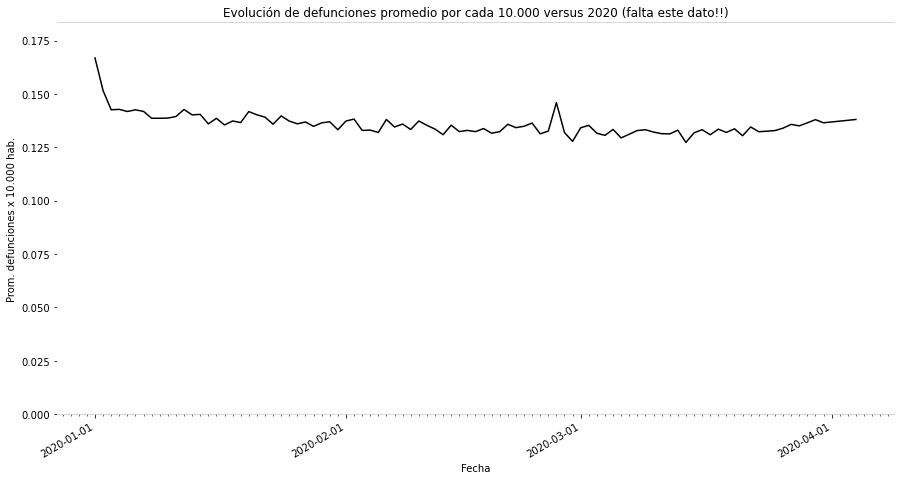

In [49]:
#--------------------------------------------
# GRÁFICO
#--------------------------------------------
# finalmente graficamos con pyplot, sientase libre cualquiera de usar algo más fancy

#Librerías necesarias
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Formateo de datos
months = mdates.MonthLocator()   # every year, decia year
days = mdates.DayLocator()  # every month, decía months
months_fmt = mdates.AutoDateFormatter('%M') # decía years_fmt

#Creamos el dataframe con solo los datos necesarios para el plot
datos = pd.DataFrame(columns = ['Fecha', 'PromDefX10000'])
datos['Fecha'] = fFilt['Fecha_Fic']
datos['PromDefX10000'] = fFilt['SUM_DEF10000']

#inciamos el gráfico y sus ejes
fig, ax = plt.subplots()
ax.plot('Fecha', 'PromDefX10000', data=datos, color='black')

# delimitamos el eje y
ax.set_ylim([0, max(datos['PromDefX10000']) + max(datos['PromDefX10000'])*.1 ])

# formateamos las marcas
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(months_fmt)
ax.xaxis.set_minor_locator(days)

# formateamos la grilla
ax.grid(False)

# Autoajuste de las etiquetas
fig.autofmt_xdate()

# seteamos leyendas y título
ax.set_xlabel('Fecha')
ax.set_ylabel('Prom. defunciones x 10.000 hab.')
ax.set_title('Evolución de defunciones promedio por cada 10.000 versus 2020 (falta este dato!!)')

#tamaño del grafico
fig.set_figheight(8)
fig.set_figwidth(15)

# color de los ejes
ax.spines['bottom'].set_color('#ccc')
ax.spines['top'].set_color('#ccc') 
ax.spines['right'].set_color('white')
ax.spines['left'].set_color('white')

plt.show()